# Projet NLP - Clustering et LSA par l'étude d'un dataset de The North Face

In [1]:
!pip install spacy -q
import spacy
spacy.__version__
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
!pip install wordcloud -q
import wordcloud

In [3]:
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

from spacy.lang.en.stop_words import STOP_WORDS

import matplotlib.pyplot as plt
import seaborn as sns

import en_core_web_sm
nlp = en_core_web_sm.load()

In [4]:
df = pd.read_csv('sample-data.csv')
df.shape

(500, 2)

In [5]:
df.head()

,id,description
0,1,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an..."


# Partie 1 : Texte pre-processing

Nettoyage du des balises HTML et des liens hypertextes + création d'une colonne description nettoyée ==> description_nohtml

In [6]:
import re
clean_tags = re.compile('<.*?>') 

def cleanhtml(raw_html):
    remhtml = re.sub(clean_tags, ' ', raw_html)
    remhtml = re.sub(r'http\S+', ' ', remhtml)
    return remhtml

df['description_nohtml']=''

for i in range(len(df)) :
    df['description_nohtml'][i] = cleanhtml(df.description[i])
    
df.head()

/tmp/ipykernel_63/3617830922.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description_nohtml'][i] = cleanhtml(df.description[i])


,id,description,description_nohtml
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an..."


Fonction qui permet de nettoyer le document

In [7]:
def cleaning(df):
    df =df.str.replace(r"\S*@\S*\s?",' ') #supprime adresse mail
    df = df.str.replace('[^\w\s]',' ') #garde les alphanumérique
    df = df.str.replace("#", " ") #hastags en texte
    df = df.str.replace('\d+', '') #enlève les chiffres
    df = df.str.replace(" +", " ") #remplace + par espace
    df = df.fillna('').apply(lambda x: x.lower())
    df = df.str.split(' ').map(lambda x: " ".join(s for s in x if len(s) > 2))
    return (df)
df['cleaned_nohtml'] = cleaning(df["description_nohtml"])

/tmp/ipykernel_63/1292236989.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df =df.str.replace(r"\S*@\S*\s?",' ') #supprime adresse mail
/tmp/ipykernel_63/1292236989.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace('[^\w\s]',' ') #garde les alphanumérique
/tmp/ipykernel_63/1292236989.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace('\d+', '') #enlève les chiffres
/tmp/ipykernel_63/1292236989.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df = df.str.replace(" +", " ") #remplace + par espace


Création des tokens et lemmas à l'aide de spacy

In [8]:
tokens = []
lemma = []
for doc in nlp.pipe(df['cleaned_nohtml'].astype('unicode').values):
    if doc.has_annotation:
        tokens.append([n.text for n in doc if n.text not in STOP_WORDS])
        lemma.append([n.lemma_ for n in doc if n.lemma_ not in STOP_WORDS])
    else: #si pas le même nombre d'entrées dans df, on ajoute un élément vide
        tokens.append(None)
        lemma.append(None)

df['desc_tokens'] = tokens
df['desc_lemma'] = lemma
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ..."
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req..."
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b..."
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch..."
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a..."


Fonction qui lemmatize le texte avant vectorisation

In [9]:
def clean_te(text):
      text = ''.join(ch for ch in text if ch.isalnum() or ch==" ")
      text = text.replace(" +"," ").lower().strip()
      return text

In [10]:
df['clean_lemma'] = df["desc_lemma"].apply(lambda x: lemmatize_text(str(x)))
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma,clean_lemma
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ...",active classic boxer reason boxer cult favorit...
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...


Création du TF-IDF, cette méthode permet d'évaluer la pertinence d'un mot dans le document (dans notre cas, dans le lemma). 

Ici, il s'agit de mesurer le nombre de fois qu'un mot apparaît dans un document, en podérant par la fréquence d'apparition de ce mot dans les autres documents. 

In [11]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['clean_lemma'])

dense = X.toarray()
dense

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Création du dataset vectorisé

In [12]:
data = pd.DataFrame(dense, 
             columns=[x for x in vectorizer.get_feature_names_out()], 
             index=["doc_{}".format(x) for x in range(0, len(df))] )
data

,abandon,ability,able,abrasion,abrasive,abroad,absolute,absorb,absorption,abstract,...,zest,zinger,zip,zipped,zipper,zippered,zippers,zipping,zips,zone
doc_0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.055164,0.271141,0.0,0.0,0.0,0.0
doc_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.160669,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
doc_495,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
doc_497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.140398,0.0,0.000000,0.045366,0.0,0.0,0.0,0.0
doc_498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.063181,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


# Partie 2 : Clustering des produits, système de recommandation
Utilisation du DBSCAN, fine tuning des paramètres

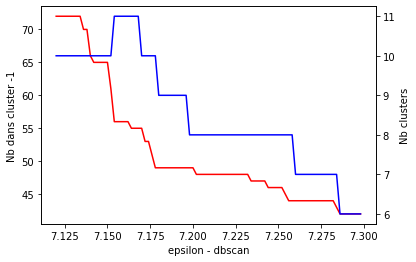

In [13]:
liste1 = []
liste2 = []
liste3 = []
for i in range(7120,7300, 2):
    db = DBSCAN(eps=i/10000, min_samples=6, metric="cosine", algorithm="auto")
    db.fit(data)
    df['db_cluster']=db.labels_
    liste1.append(len(df[df['db_cluster'] == -1]))
    liste2.append(df['db_cluster'].nunique())
    liste3.append(i/1000)
    
fig, ax1 = plt.subplots() 

ax1.set_xlabel('epsilon - dbscan') 
ax1.set_ylabel('Nb dans cluster -1') 
ax1.plot(liste3,liste1, color = 'red') 

ax2 = ax1.twinx() 
ax2.plot(liste3,liste2, color = 'blue')  

plt.ylabel('Nb clusters') 

plt.show()
fig.clear(True)
liste1 = []
liste2 = []
liste3 = []


In [14]:
db = DBSCAN(eps=0.7165, min_samples=6, metric="cosine", algorithm="auto")
db.fit(data)

DBSCAN(eps=0.7165, metric='cosine', min_samples=6)

In [26]:
df['db_cluster']=db.labels_
print('On trouve {} clusters. '.format(df['db_cluster'].nunique()))

On trouve 11 clusters. 


Répartition des documents dans les onze clusters

In [16]:
df['db_cluster'].value_counts().sort_values(ascending=False)

 0    286
 4     60
-1     55
 1     31
 6     24
 2      9
 3      9
 5      8
 7      7
 8      6
 9      5
Name: db_cluster, dtype: int64

In [17]:
df['product'] = df['description'].apply(lambda x:x.split(' - ')[0])
df.head()

,id,description,description_nohtml,cleaned_nohtml,desc_tokens,desc_lemma,clean_lemma,db_cluster,product
0,1,Active classic boxers - There's a reason why o...,Active classic boxers - There's a reason why o...,active classic boxers there reason why our box...,"[active, classic, boxers, reason, boxers, cult...","[active, classic, boxer, reason, boxer, cult, ...",active classic boxer reason boxer cult favorit...,0,Active classic boxers
1,2,Active sport boxer briefs - Skinning up Glory ...,Active sport boxer briefs - Skinning up Glory ...,active sport boxer briefs skinning glory requi...,"[active, sport, boxer, briefs, skinning, glory...","[active, sport, boxer, brief, skin, glory, req...",active sport boxer brief skin glory require mo...,-1,Active sport boxer briefs
2,3,Active sport briefs - These superbreathable no...,Active sport briefs - These superbreathable no...,active sport briefs these superbreathable fly ...,"[active, sport, briefs, superbreathable, fly, ...","[active, sport, brief, superbreathable, fly, b...",active sport brief superbreathable fly brief m...,0,Active sport briefs
3,4,"Alpine guide pants - Skin in, climb ice, switc...","Alpine guide pants - Skin in, climb ice, switc...",alpine guide pants skin climb ice switch rock ...,"[alpine, guide, pants, skin, climb, ice, switc...","[alpine, guide, pant, skin, climb, ice, switch...",alpine guide pant skin climb ice switch rock t...,0,Alpine guide pants
4,5,"Alpine wind jkt - On high ridges, steep ice an...","Alpine wind jkt - On high ridges, steep ice an...",alpine wind jkt high ridges steep ice and anyt...,"[alpine, wind, jkt, high, ridges, steep, ice, ...","[alpine, wind, jkt, high, ridge, steep, ice, a...",alpine wind jkt high ridge steep ice alpine ja...,0,Alpine wind jkt


CLUSTER n°0


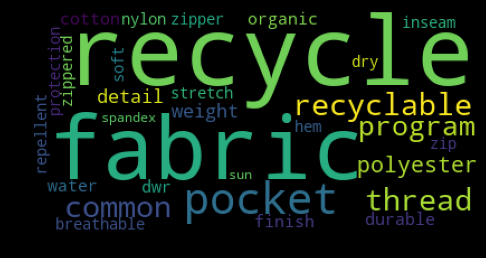



CLUSTER n°1


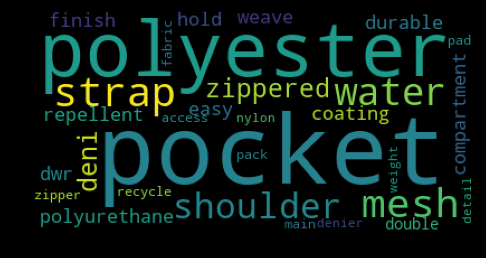



CLUSTER n°2


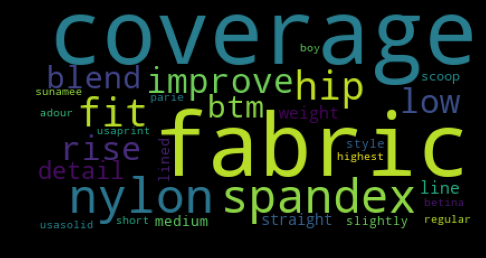



CLUSTER n°3


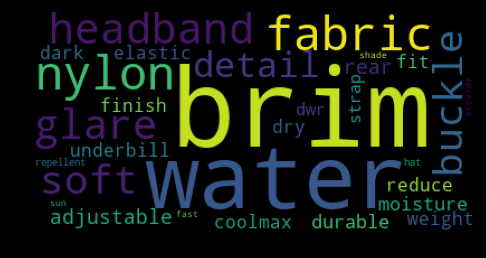



CLUSTER n°4


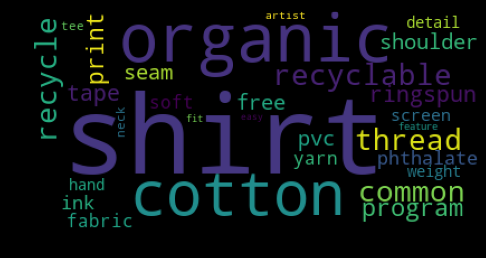



CLUSTER n°5


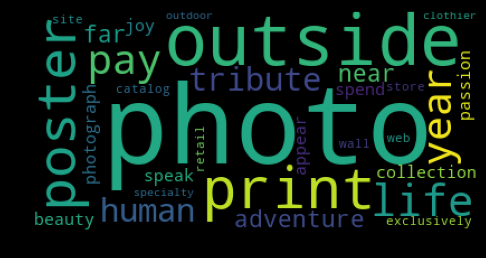



CLUSTER n°6


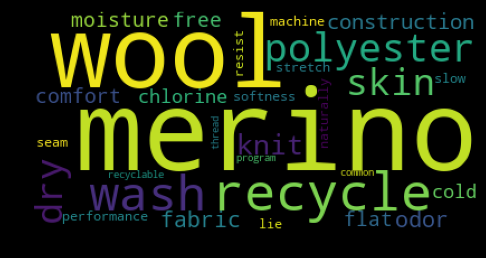



CLUSTER n°7


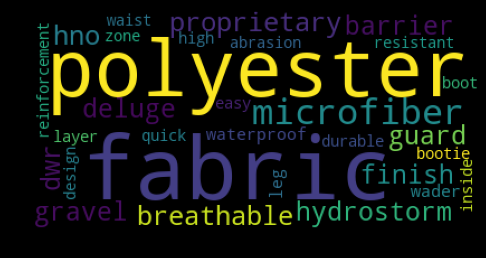



CLUSTER n°8


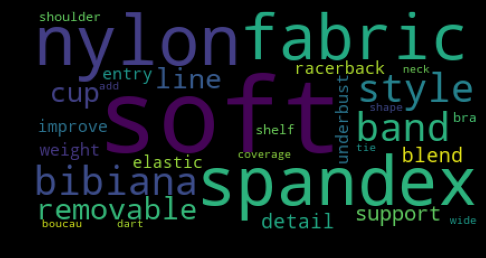



CLUSTER n°9


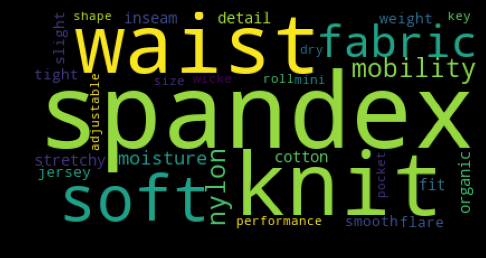

In [18]:
import matplotlib.pyplot as plt
import wordcloud
for i in range(0,10):
    text_merge_clean_token = ''
    df_temp = df[df['db_cluster'] == i]
    for j in range(0, len(df_temp)):
        text_merge_clean_token += str(df_temp['clean_lemma'].iloc[j])
    print('CLUSTER n°' + str(i))
    wd = wordcloud.WordCloud(collocations=False, max_words=30)
    cloud = wd.generate(nlp(text_merge_clean_token).text)
    fig = plt.figure(
    figsize = (8, 5),
    facecolor = 'k',
    edgecolor = 'k')
    plt.imshow(cloud )

    # Remove trailing logs 
    plt.show()
    print('\n')

Fonction de recommandation de produits similaires

In [19]:
def find_similar_items(item_id):
    item_id = int(item_id)
    db_cluster_target = df[df['id'] == item_id]['db_cluster'].tolist()[0]
    df_filtre = df[df['db_cluster'] == db_cluster_target]
    result = df_filtre['product'].sample(5).to_list()
    return result
find_similar_items(input())

 8


['Solid betina btm',
 'Print bayonne btm',
 'Print banded betina btm',
 'Solid adour btm',
 'Print adour btm']

# Partie 3 : Topic Modeling
LSA : décomposition des documents et recherche des topics pertinents à l'aide de TruncatedSVD

In [20]:
liste = []
for i in range(10,21):
    svd = TruncatedSVD(n_components=i, algorithm='randomized', n_iter=50)
    lsa = svd.fit_transform(X)
    var_explained = svd.explained_variance_ratio_.sum()
    liste.append(var_explained)
print('La variance max est de : '+str(max(liste))+' pour n_components = ' +str(10 + liste.index(max(liste))))

La variance max est de : 0.3083939563977149 pour n_components = 20


In [21]:
svd_model = TruncatedSVD(n_components=12, algorithm='randomized', random_state=122)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, columns = ["topic " + str(i) for i in range(0,12)])
topic_encoded_df["documents"] = df['clean_lemma']
topic_encoded_df

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,documents
0,0.263791,-0.045175,0.189118,0.093923,-0.116628,0.005621,-0.083401,-0.012633,0.109550,-0.105274,-0.028470,0.003982,active classic boxer reason boxer cult favorit...
1,0.297925,-0.050103,0.105105,0.103914,-0.022646,0.143172,0.003825,-0.012213,0.054376,-0.125470,-0.046818,0.065124,active sport boxer brief skin glory require mo...
2,0.292468,-0.077717,0.116125,0.030186,-0.032978,0.121639,0.090709,0.068236,0.063899,-0.053765,-0.026926,0.117992,active sport brief superbreathable fly brief m...
3,0.412154,-0.257310,-0.126847,-0.137081,0.045621,0.010400,-0.043747,-0.058454,-0.086250,-0.158982,-0.009690,-0.100747,alpine guide pant skin climb ice switch rock t...
4,0.397769,-0.267314,-0.016039,-0.238810,-0.043519,-0.052733,0.031909,0.051439,-0.146475,-0.123177,-0.010488,-0.218244,alpine wind jkt high ridge steep ice alpine ja...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.337746,-0.068746,0.393178,0.083195,-0.245207,-0.033737,-0.144137,-0.088724,0.250923,-0.207795,-0.069561,-0.037983,cap cut loose madden crowd search undone capil...
496,0.373317,-0.064060,0.496418,-0.007356,-0.294797,-0.068535,-0.089386,0.003506,0.246606,-0.084752,-0.057508,-0.134931,cap crew crew edge fickle weather clearing con...
497,0.331161,-0.227061,-0.064381,-0.245727,-0.002538,-0.223531,0.046710,-0.184507,-0.010130,0.078313,0.025265,0.063203,time shell need use morning time umbrella time...
498,0.329596,0.074343,-0.141413,0.347220,0.048725,-0.098251,-0.199943,0.008920,0.058537,0.031354,-0.021381,0.028335,wear cargo short wear cargo short bask glory s...


/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='topic 1', ylabel='topic 2'>

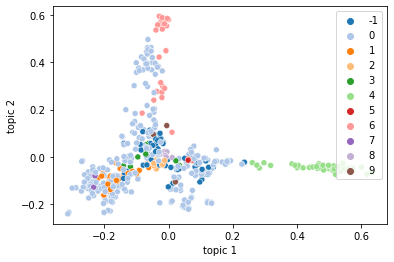

In [22]:
sns.scatterplot("topic 1","topic 2",data= topic_encoded_df, hue = db.labels_, palette=sns.color_palette("tab20")[0:11])

Permet de trouver le topic principal par document (ou produit)

In [23]:
def main_topic(row):
    topics = np.abs(row)
    main_topic = topics.sort_values(ascending=False).index[0]
    return main_topic

topic_encoded_df.loc[:, 'main_topic'] = 0

for i, row in topic_encoded_df.iloc[:,:-2].iterrows():
    topic_encoded_df.loc[i, 'main_topic'] = main_topic(row)

topic_encoded_df.head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,topic 11,documents,main_topic
0,0.263791,-0.045175,0.189118,0.093923,-0.116628,0.005621,-0.083401,-0.012633,0.109550,-0.105274,-0.028470,0.003982,active classic boxer reason boxer cult favorit...,topic 0
1,0.297925,-0.050103,0.105105,0.103914,-0.022646,0.143172,0.003825,-0.012213,0.054376,-0.125470,-0.046818,0.065124,active sport boxer brief skin glory require mo...,topic 0
2,0.292468,-0.077717,0.116125,0.030186,-0.032978,0.121639,0.090709,0.068236,0.063899,-0.053765,-0.026926,0.117992,active sport brief superbreathable fly brief m...,topic 0
3,0.412154,-0.257310,-0.126847,-0.137081,0.045621,0.010400,-0.043747,-0.058454,-0.086250,-0.158982,-0.009690,-0.100747,alpine guide pant skin climb ice switch rock t...,topic 0
4,0.397769,-0.267314,-0.016039,-0.238810,-0.043519,-0.052733,0.031909,0.051439,-0.146475,-0.123177,-0.010488,-0.218244,alpine wind jkt high ridge steep ice alpine ja...,topic 0


In [24]:
topic_encoded_df['main_topic'].value_counts()

topic 0     263
topic 1      61
topic 6      38
topic 2      36
topic 7      30
topic 3      21
topic 11     13
topic 4      12
topic 5      10
topic 10      8
topic 8       5
topic 9       3
Name: main_topic, dtype: int64

Création de WordCloud par topic généré.

Topic n°0


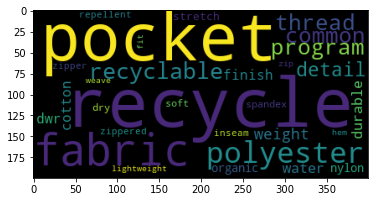

Topic n°1


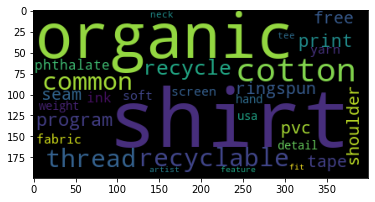

Topic n°2


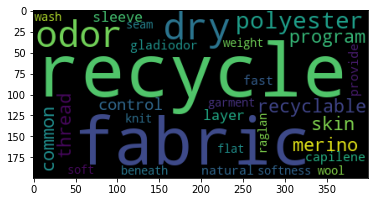

Topic n°3


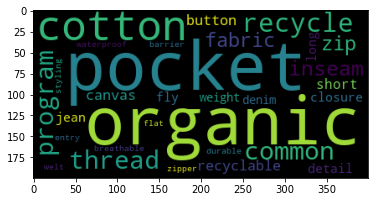

Topic n°4


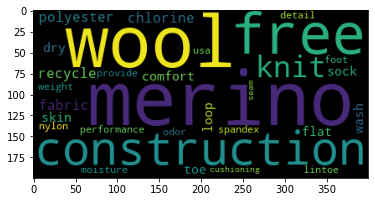

Topic n°5


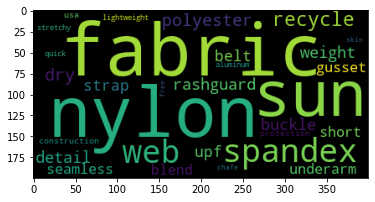

Topic n°6


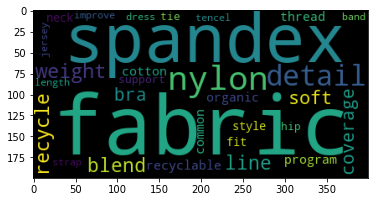

Topic n°7


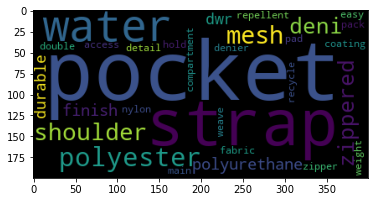

Topic n°8


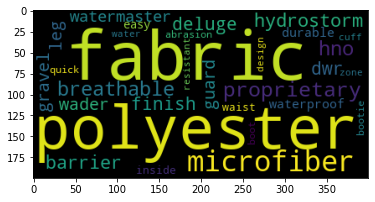

Topic n°9


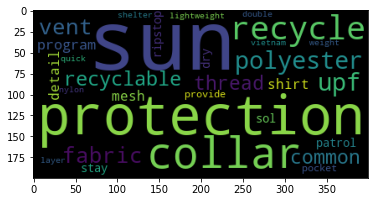

Topic n°10


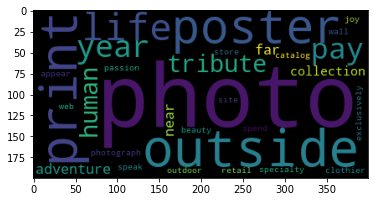

Topic n°11


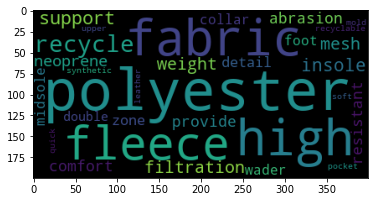

In [25]:
wd = wordcloud.WordCloud(collocations=False, max_words=30)
col = [c for c in topic_encoded_df.columns if 'topic ' in c]
inc = 0
for topic in col:
    print('Topic n°' + str(inc))
    texts = " ".join(topic_encoded_df.loc[topic_encoded_df['main_topic']==topic,'documents'])
    cloud = wd.generate(texts)
    plt.imshow(cloud)
    plt.show()
    inc += 1

## Conclusion

<ul>
    <li>DBScan est plus utile pour les systèmes de recommandations car le LSA ne permet pas de distinguer des catégories uniques, les documents ayant un pied dans chacun des topics</li>
    <li>Malgré un pré-processing complet, il est difficile de mieux organiser le nettoyage afin d'être assez discriminant sur le clustering sans avoir trop d'outliers</li>
</ul>